In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
import random
from sklearn import preprocessing

In [2]:
# defining global variable path
image_path = "/home/shophy/Projects/Identifying-Snake-Breed/dataset"
label_path = "/home/shophy/Projects/Identifying-Snake-Breed/dataset/train.csv"

In [3]:
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

### Load the images and the labels (from path to array)

In [5]:
def load_images_labels(image_path, label_path):
    image_files = sorted([os.path.join(image_path, 'train', file)
         for file in os.listdir(image_path + "/train") if file.endswith('.jpg')])
    random.seed(42)
    random.shuffle(image_files)
    
    labels_df = pd.read_csv(label_path)
    labels_dict = {}
    for pair in labels_df.iloc[0:,0:2].values:
        labels_dict[pair[0]] = pair[1]
        
    labels = []
    for img in image_files:
        labels.append(labels_dict[img.split('/')[-1].split('.')[0]])
    
    lb = preprocessing.LabelBinarizer()
    lb.fit(labels)
    classes = lb.classes_
    
    return image_files, labels, classes

In [6]:
image_files, labels, classes = load_images_labels(image_path, label_path)

### Preprocessing the images
1. Resizing
2. Denoising
3. Segmentation & Morphology

In [41]:
def processing(data):
    img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in data]
    original = img[0]
    
    # Resizing the images
    height = 225
    width = 225
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)
    print('Original size',img[0].shape)
    print("Resized Shapes", res_img[1].shape)
    display(original,res_img[0],'Original','Resized')
    
    # Denoising the images
    no_noise = []
    for i in range(len(res_img)):
        blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
        no_noise.append(blur)
    display(original, no_noise[0], 'Original', 'Blured')
    
    # Segmenting the images
    thresh_ls, sure_bg_ls, markers_ls = [],[],[]
    for i in range(len(no_noise)):
        gray = cv2.cvtColor(no_noise[i], cv2.COLOR_RGB2GRAY)
        ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        thresh_ls.append(thresh)
        
        # Further noise removal
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        # sure background area
        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        sure_bg_ls.append(sure_bg)
        
        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)
        # Add one to all labels so that sure background is not 0, but 1
        markers = markers + 1
        # Now, mark the region of unknown with zero
        markers[unknown == 255] = 0
        markers_ls.append(markers)
        
    display(original, thresh_ls[0], 'Original', 'Segmented')
    display(original, sure_bg_ls[0], 'Original', 'Segmented Background')
    image = no_noise[0]
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]
    display(image, markers_ls[0], 'Original', 'Marked')


Original size (96, 128, 3)
Resized Shapes (225, 225, 3)


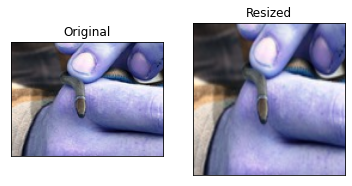

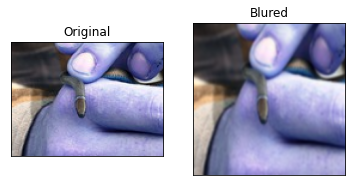

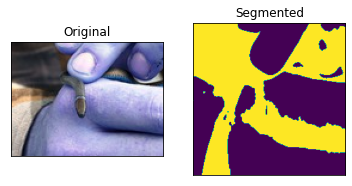

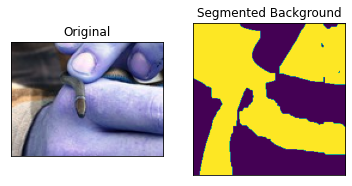

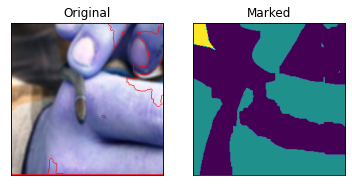

In [42]:
processing(image_files)